In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import math
from xgboost import XGBRegressor

In [2]:
# Previous lines are to test the Word2Vec model
# Code starts here
# Reading Hansen and SMILES data from gpHSP
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')

mol_smiles = gpHSP_data['SMILES']
hansen_d = gpHSP_data['hansen_d']
hansen_p = gpHSP_data['hansen_p']
hansen_h = gpHSP_data['hansen_h']
mol_number = gpHSP_data['number']
mol_name = gpHSP_data['Molecule']

hansen_total = np.sqrt((hansen_d*hansen_d + hansen_p*hansen_p + hansen_h*hansen_h))

In [3]:
# generate fingeprints: Morgan fingerprint with radius 8
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 8, nBits=1024) for x in gpHSP_data['SMILES']]
np_fps = np.asarray(fps)
np_fps.shape

#maccs_fps = [MACCSkeys.GenMACCSKeys (Chem.MolFromSmiles(x)) for x in gpHSP_data['smiles']]

(1183, 1024)

Fold:1, Train set: 985, Test set:198
2.1093300781015194
3.1719371519391335
0.58217971769458


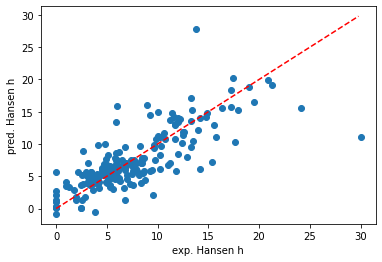

Fold:2, Train set: 986, Test set:197
2.208321885023323
3.7722563217346026
0.5565718630563313


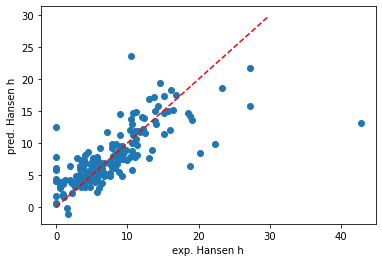

Fold:3, Train set: 986, Test set:197
2.2130997129115584
3.862140537783342
0.4768902685760129


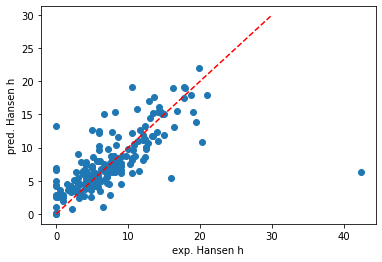

Fold:4, Train set: 986, Test set:197
2.1133703675064335
3.2751445244636765
0.5832073362248258


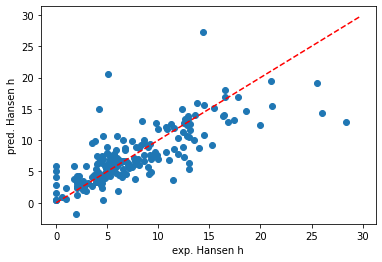

Fold:5, Train set: 986, Test set:197
2.1842911006230388
3.2970788680245393
0.5075620797278657


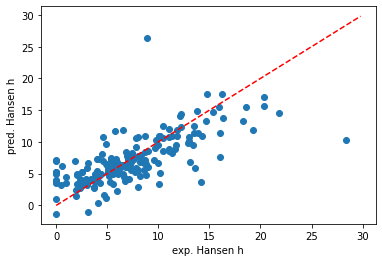

Fold:6, Train set: 986, Test set:197
2.3948282202790834
3.8791803317954683
0.4571178559627441


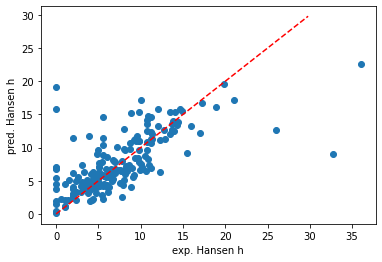

In [4]:
# split the data into 6 folds.  
# use'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=6, shuffle=True, random_state=42)

cnt = 1

# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(np_fps, hansen_h):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    fps_train, fps_test = np_fps[train_index], np_fps[test_index]
    hansen_train, hansen_test = hansen_h[train_index], hansen_h[test_index]
    index_train, index_test = mol_number[train_index], mol_number[test_index]
    smiles_train, smiles_test = mol_smiles[train_index], mol_smiles[test_index]
    
    # training model
    model = XGBRegressor().fit(fps_train, hansen_train)
    hansen_pred = model.predict(fps_test)
    
    print(mean_absolute_error (hansen_test, hansen_pred))
    print(math.sqrt(mean_squared_error(hansen_test, hansen_pred)))
    print(r2_score (hansen_test, hansen_pred))

    pd_hansen_pred = pd.DataFrame(hansen_pred, columns=["pred"])
    xg_output = pd.concat((index_test.reset_index(), smiles_test.reset_index(), hansen_test.reset_index(), pd_hansen_pred), ignore_index=True, axis=1)
    xg_output.to_csv(f'fps_xgboost_hansen_h_fold_{cnt}.csv')

    ln = np.arange(0, 30, 0.2)
    plt.plot(ln, ln,'r--')
    plt.scatter(hansen_test, hansen_pred)
    plt.plot(color='green')

    plt.xlabel('exp. Hansen h')
    plt.ylabel('pred. Hansen h')
    plt.show()
    
    cnt += 1
    